В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.25, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [2]:
# Зчитування даних у змінну raw_df
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/train.csv')

# Видаляємо стовпці, які зайві для моделі
raw_df.drop(['id', 'CustomerId', 'Surname'], axis = 1, inplace = True)

# Розподіл на тренувальний і валідаційний набори
train_df, val_df = split_train_val(raw_df, 'Exited')

# Визначення вхідних ознак і цільового стовпця
input_cols = list(train_df.columns)[:-1]
target_col = list(train_df.columns)[-1]

# Розподіл тренувальних і валідаційних наборів на вхідні ознаки і цільову змінну
train_inputs, train_targets = separate_inputs_targets(train_df, input_cols, target_col)
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols, target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [3]:
# Перетворення типу категоріальних даних на categorical у тренувальному і валідаційному наборах

cat_features = train_inputs.select_dtypes(include = 'object').columns.tolist()
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [4]:
from xgboost import XGBClassifier

In [5]:
# Тренування ансамблю і виведення основних метрик для порівняння на тренувальних і валідаційних даних

xgb_clf = XGBClassifier(
    max_depth = 3,
    n_estimators = 15,
    enable_categorical = True,  # для категорійних ознак
    #use_label_encoder = False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing = np.nan,  # явне вказування пропущених значень
    #device='cuda'
)

xgb_clf.fit(train_inputs, train_targets)

train_pred = xgb_clf.predict(train_inputs)
val_pred = xgb_clf.predict(val_inputs)

print(classification_report(train_targets, train_pred, digits = 4))
print(classification_report(val_targets, val_pred, digits = 4))

              precision    recall  f1-score   support

         0.0     0.9172    0.9646    0.9403      8961
         1.0     0.8264    0.6592    0.7334      2289

    accuracy                         0.9025     11250
   macro avg     0.8718    0.8119    0.8369     11250
weighted avg     0.8988    0.9025    0.8982     11250

              precision    recall  f1-score   support

         0.0     0.9139    0.9625    0.9376      2987
         1.0     0.8146    0.6448    0.7198       763

    accuracy                         0.8979      3750
   macro avg     0.8642    0.8037    0.8287      3750
weighted avg     0.8937    0.8979    0.8933      3750



In [6]:
# Функція для підрахунку метрики AUROC

def pred_auroc(model, inputs, targets, name = ''):

    # Predict probabilities
    pred_proba = model.predict_proba(inputs)[:, 1]
    
    # Compute AUROC
    roc_auc = roc_auc_score(targets, pred_proba)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2%}")
  
    return roc_auc

In [7]:
# Розрахунок точності на тренувальному і валідаційному наборах за допомогою AUROC

roc_auc_train = pred_auroc(xgb_clf, train_inputs, train_targets, 'Training')
roc_auc_val = pred_auroc(xgb_clf, val_inputs, val_targets, 'Validation')

Area under ROC score on Training dataset: 93.77%
Area under ROC score on Validation dataset: 93.68%


**Висновок**:\
Модель хороша, немає ні high bias (значення `AUROC` досить високі), ні high variance (значення `AUROC` на валідаційному наборі близьке до того, що на тренувальному – модель добре генералізує).\
В порівнянні з моделлю, яка була отримана з використанням DecisionTrees у попередньому ДЗ, ця модель кращої якості. `AUROC` вищий і на тренувальній, і на валідаційній вибірці і в порівнянні з моделлю, де шукались оптимальні параметри за допомогою `RandomizedSearchCV`, і в порівнянні з моделлю, де параметри дерева рішень підбирались вручну (скрін нижче).

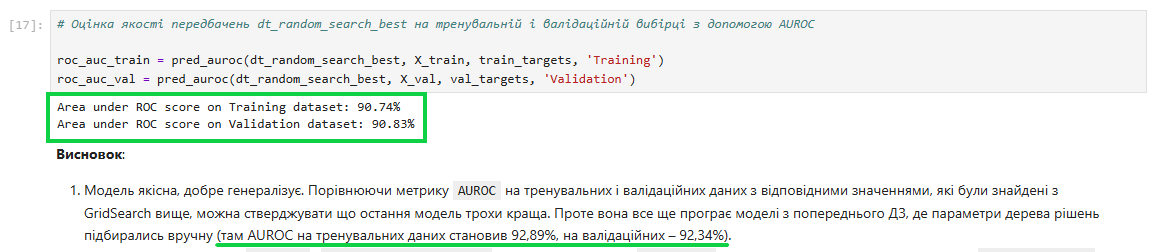

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [8]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [9]:
def objective(params):
    clf = XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        #use_label_encoder=False,
        missing=np.nan,
        #device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)
    pred = clf.predict_proba(val_inputs)[:, 1]
    roc_auc = roc_auc_score(val_targets, pred)

    return {'loss': -roc_auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    #use_label_encoder=False,
    missing=np.nan,
    #device='cuda',
)

final_clf.fit(train_inputs, train_targets)
final_train_pred = final_clf.predict(train_inputs)
final_val_pred = final_clf.predict(val_inputs)

print(classification_report(train_targets, final_train_pred, digits = 4))
print(classification_report(val_targets, final_val_pred, digits = 4))

# Розрахунок точності на тренувальному і валідаційному наборах за допомогою AUROC
final_roc_auc_train = pred_auroc(final_clf, train_inputs, train_targets, 'Training')
final_roc_auc_val = pred_auroc(final_clf, val_inputs, val_targets, 'Validation')

100%|███████████████████████████████████████████████| 20/20 [00:02<00:00,  9.64trial/s, best loss: -0.9382492329144949]
Найкращі гіперпараметри:  {'colsample_bytree': 0.5297295760829142, 'gamma': 0.06587894081095658, 'learning_rate': 0.03227375783695948, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 100, 'reg_alpha': 0.45901051305287954, 'reg_lambda': 0.9818570531182738, 'subsample': 0.5084099310392434}
              precision    recall  f1-score   support

         0.0     0.9071    0.9751    0.9399      8961
         1.0     0.8621    0.6090    0.7138      2289

    accuracy                         0.9006     11250
   macro avg     0.8846    0.7921    0.8268     11250
weighted avg     0.8979    0.9006    0.8939     11250

              precision    recall  f1-score   support

         0.0     0.9018    0.9742    0.9366      2987
         1.0     0.8528    0.5845    0.6936       763

    accuracy                         0.8949      3750
   macro avg     0.8773    0.7794    0.

**Висновок**:\
Модель зі знайденими за допомогою бібліотеки `Hyperopt` оптимальними гіперпараметрами більш якісна за попередню. `AUROC` покращився і на тренувальних даних (з 93,77% до 94,00%), і на валідаційних (з 93,68% до 93,82%).

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [10]:
from lightgbm import LGBMClassifier

In [11]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in cat_features]

In [12]:
lgb_clf = LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

train_pred = lgb_clf.predict(train_inputs)
val_pred = lgb_clf.predict(val_inputs)

print(classification_report(train_targets, train_pred, digits = 4))
print(classification_report(val_targets, val_pred, digits = 4))

# Розрахунок точності на тренувальному і валідаційному наборах за допомогою AUROC
roc_auc_train = pred_auroc(lgb_clf, train_inputs, train_targets, 'Training')
roc_auc_val = pred_auroc(lgb_clf, val_inputs, val_targets, 'Validation')

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2, will be overridden by cat_feature=1,2. Current value: categorical_feature=1,2
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2289, number of negative: 8961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 11250, number of used features: 10
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203467 -> initscore=-1.364767
[LightGBM] [Info] Start training from score -1.364767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

**Висновок**:\
Модель хороша, немає ні high bias (значення AUROC досить високі), ні high variance (значення AUROC на валідаційному наборі близьке до того, що на тренувальному – модель добре генералізує).\
В порівнянні з попередньою моделлю, яка була отримана з використанням XGBoostClassifier, ця показала гірші результати, судячи з метрики `AUROC`. На тренувальному наборі 93,88% в останній моделі проти 94,00% в попередній. І на валідаційному 93,69% в останній моделі проти 93,82% в попередній.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [13]:
def objective(params):
    clf = LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
    pred = clf.predict_proba(val_inputs)[:, 1]
    roc_auc = roc_auc_score(val_targets, pred)

    return {'loss': -roc_auc, 'status': STATUS_OK}
    
# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb_clf = LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

final_lgb_train_pred = final_lgb_clf.predict(train_inputs)
final_lgb_val_pred = final_lgb_clf.predict(val_inputs)

print(classification_report(train_targets, final_lgb_train_pred, digits = 4))
print(classification_report(val_targets, final_lgb_val_pred, digits = 4))

# Розрахунок точності на тренувальному і валідаційному наборах за допомогою AUROC
final_lgb_roc_auc_train = pred_auroc(final_lgb_clf, train_inputs, train_targets, 'Training')
final_lgb_roc_auc_val = pred_auroc(final_lgb_clf, val_inputs, val_targets, 'Validation')

[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2, will be overridden by cat_feature=1,2. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2289, number of negative: 8961                                                   
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 843                                                                                       
[LightGBM] [Info] Number of data points in the train set: 11250, number of used features: 10                           
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203467 -> initscore=-1.364767                                        
[LightGBM] [Info] Start training from score -1.364767                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gai

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements                
[LightGBM] [Warning] No further splits w

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Stopped training be

**Висновок**:\
Судячи зі значень метрики `AUROC` на тренувальній і валідаційній вибірках, модель якісна (немає ні high bias, ні суттєвого high variance).\
Якщо порівнювати з попередньою моделлю, де гіперпараметри підбирались вручну, `AUROC` покращився на тренувальних даних (97,48% проти 93,88%), але погіршився на валідаційних (93,08% проти 93,69%). В порівнянні з попередньою остання модель має гіршу здатність до генералізації.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

**Висновок**:\
З усіх експериментів у цьому ДЗ найкращі результати показала модель XGBoost з використанням бібліотеки Hyperopt для пошуку гіперпараметрів. Метрика `AUROC` у цьому експерименті мала найбільше значення для валідаційного набору серед усіх експериментів (93,82%).

In [14]:
# Зчитування тестових даних

test_raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/test.csv')

In [15]:
# Видалення зайвих для моделі стовпців, зміна типу категоріальних стовпців

test_raw_df.drop(['id', 'CustomerId', 'Surname'], axis = 1, inplace = True)
test_raw_df[cat_features] = test_raw_df[cat_features].astype('category')

In [16]:
# Знаходження передбачень на тестових даних, формування файлу submission

test_raw_df['Exited'] = final_clf.predict_proba(test_raw_df)[:, 1]

submission_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv')
submission_df.Exited = test_raw_df.Exited
submission_df.to_csv('submission.csv', index = False)

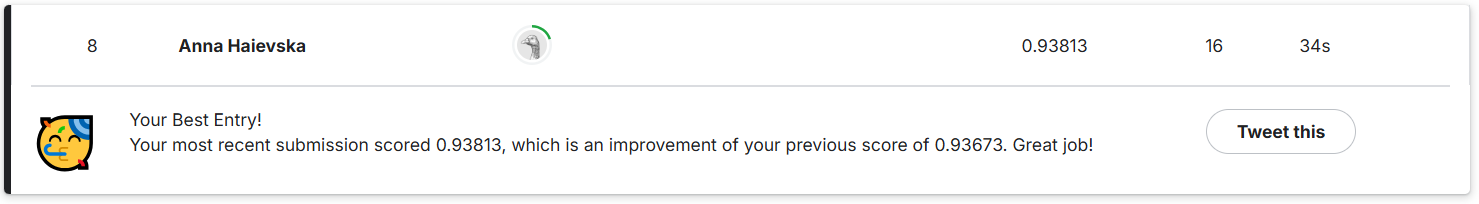